# Autoencoders

## Шаг 1
В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Вам нужно скачать оттуда lfw-deepfunneled.tgz и lfw_attributes.txt. Архив .tgz нужно распаковать =) После этого у вас появится папка с папками с лицами людей.

P.S. Не забудьте разбить выборку на train и test (нет, не в отдельные папки, а при загрузке в память компьютера в ноутбуке =))

P.P.S. для улучшения обучения автоэекодера полезно перевести величины пикселей картинки в отрезок [0, 1] (изначально они в интервале [0, 255]), а также привести их к типу float. Также удобно для начала сделать resize картинок в размер ~ (45, 45), чтобы обучить автоэнкодер было проще. Потом вы можете увеличить картинки как хотите, и усложнять вместе с ними автоэнкодер.

In [33]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
zip_path = '/content/gdrive/My Drive/Colab Notebooks/final/lfw.tgz'
data_path = '/content/gdrive/My Drive/Colab Notebooks/final/'

In [0]:
import urllib.request
import tarfile

print('Downloading dataset ...')

url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'  
urllib.request.urlretrieve(url, zip_path)  

print('Dataset downloaded!')

tar = tarfile.open(zip_path, "r:gz")
tar.extractall(data_path)
tar.close()
print('Dataset uzipped!')

## Шаг 2

Пока скачивается датасет, можно набросать план действий:

Разботать и реализовать автоэнкодер. Обычный (как на картинке)
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

Вектор в середине (выход ancoder'а) называется латентным вектором/представлением картинки.

Для начала стоит почитать статьи/посты про автоэнкодеры. Автоэнкодер будет представлять собой класс-наследник nn.Module (как и обычно). Параметры типа кол-ва слоев, кол-ва нейронов в каждом слое и прочие советую вынести в отдельные переменные, чтобы потом было проще менять (вряд ли вы сразу угадаете, сколько слоев/нейронов вам нужно). Ну и, собственно, натренировать автоэекодер =) 

В процессе тренировки автоэекодера полезно следить не только за лоссом, но и за тем, как автоэнкодер восстанавливает каринки. Не поленитесь и напишите код, который каждую эпоху (например) будет прогонять через автоэнкодер несколько картинок из val выборки и выводить на экран полученные реконструкции.

P.S. какой будет структура автоэнкодера -- свертки, только fully-connected -- решать Вам. Можно заставить работать и так, и так. Эксперементируйте =) 

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import pickle
import random
from torch import nn
from PIL import Image
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
from torchvision.utils import save_image

In [0]:
class Faces(Dataset):
    def __init__(self, root_dir=data_path, transform=None, dumped_dataset_path=None):
        self.root_dir = root_dir
        
        if transform is not None:
          self.transform = transform
        else:
          self.transform = transforms.Compose([
              transforms.Resize((125, 125)),
              transforms.RandomChoice([
              transforms.RandomRotation(10),
              transforms.RandomAffine(10),
              transforms.RandomHorizontalFlip(),
              transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
              ]),
              transforms.ToTensor(), ])
          
        if dumped_dataset_path is None:
          self.dataset = [] 

          i = 0
          for filename in os.listdir(self.root_dir  + 'lfw'):
            for image in os.listdir(self.root_dir + 'lfw/' + filename + '/'):
              i += 1
              if i % 100 == 0: 
                print(i, self.root_dir + 'lfw/' + filename + '/' + image)

              img = Image.open(self.root_dir + 'lfw/' + filename + '/' + image)
              if self.transform:
                img = self.transform(img)
              self.dataset.append(img)
        else:
          with open(dumped_dataset_path, "rb") as data:
            self.dataset = pickle.load(data)
            
        self.X_train = self.dataset[:int(len(self.dataset)*0.9)]
        self.X_test = self.dataset[int(len(self.dataset)*0.9):]

    def __len__(self):
        return len(self.X_train)
    def __getitem__(self, idx):
        return  self.X_train[idx]

In [0]:
face_dataset = Faces(dumped_dataset_path=data_path + "faces.bin")

In [0]:
# import pickle

# with open(data_path + "faces.bin", "wb") as output:
#     pickle.dump(face_dataset.dataset, output)
    
# with open(data_path + "faces.bin", "rb") as data:
#     face_dataset.dataset = pickle.load(data)

11909
[3952, 3811, 970, 10315]
torch.Size([125, 125, 3])
torch.Size([125, 125, 3])
torch.Size([125, 125, 3])
torch.Size([125, 125, 3])


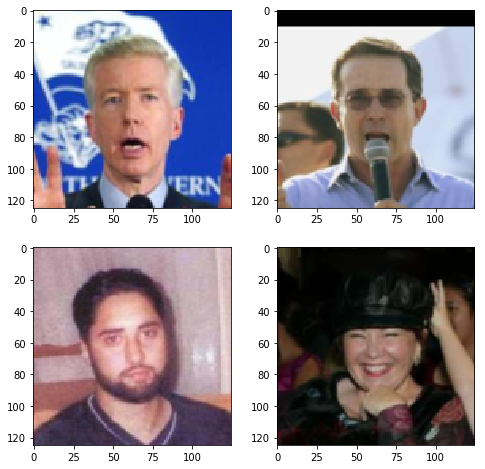

In [39]:
from random import randint

print(len(face_dataset))
x = [randint(0, len(face_dataset) - 1) for p in range(0, 4)]
print(x)

fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 2
for i in range(1, columns*rows + 1):
  fig.add_subplot(rows, columns, i)
  print(face_dataset[x[i-1]].permute(1, 2, 0).shape)
  plt.imshow(face_dataset[x[i-1]].permute(1, 2, 0))
plt.show()

In [0]:
# hyperparameters
learning_rate = 1e-5
batch_size=128
num_epochs = 300

In [0]:
from torch.nn.functional import interpolate

img_height = 125
img_length = 125

class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
      
      
class AutoencoderConv(nn.Module):
    def __init__(self):
      super(AutoencoderConv, self).__init__()
      self.latent_size = 256
      
      self.encoder = nn.Sequential(
          nn.Conv2d(3, 16, kernel_size=5, stride=2),
          nn.ReLU(True),
          nn.Conv2d(16, 32,kernel_size=5, stride=2),
          nn.ReLU(True),
          Flatten(),
          nn.Linear(26912, 2048), 
          nn.ReLU(True), 
          nn.Linear(2048, self.latent_size), 
          nn.Tanh())
      
      self.decoder = nn.Sequential(
          nn.Linear(self.latent_size, 2048),
          nn.ReLU(True), 
          nn.Linear(2048, 26912),
          nn.ReLU(True), 
          View(-1, 32, 29, 29),
          nn.ConvTranspose2d(32,16,kernel_size=5, stride=2),
          nn.ReLU(True),
          nn.ConvTranspose2d(16,3,kernel_size=5, stride=2),
#          nn.ReLU(True),
          nn.Tanh())
        
    def forward(self, x):       
      latent_code = self.encoder(x)
      reconstruction = self.decoder(latent_code)

      return reconstruction, latent_code

    def generate_random_face(self):
      latent_code =  np.tanh(np.random.randn(self.latent_size))
      latent_code = Variable(torch.from_numpy(latent_code).float()).cuda()
      generated = self.decoder(latent_code)
      return generated

In [0]:
model = AutoencoderConv().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [0]:
dataloader = DataLoader(face_dataset, batch_size=batch_size, shuffle=True)

In [0]:
def to_img(x):
  x = x.clamp(0, 1)
  x = x.view(3, img_height, img_length)
  return x

In [0]:
# model.load_state_dict(torch.load(data_path + './sim_autoencoder.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [49]:
for epoch in range(num_epochs):
    for img in dataloader:
        img = Variable(img).cuda()
        
        # forward
        reconstruction, latent_code = model(img)
        
        loss = criterion(reconstruction, img)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    
    if epoch % 30 == 0:
      pic = to_img(reconstruction[0].cpu().data)
      save_image(pic, data_path + '/generated/gen/' + 'image_{}.png'.format(epoch))

torch.save(model.state_dict(), data_path + './autoencoder.pth')

epoch [1/300], loss:0.2010
epoch [2/300], loss:0.1095
epoch [3/300], loss:0.1536
epoch [4/300], loss:0.1137
epoch [5/300], loss:0.0820
epoch [6/300], loss:0.0568
epoch [7/300], loss:0.0652
epoch [8/300], loss:0.0548
epoch [9/300], loss:0.0610
epoch [10/300], loss:0.0539
epoch [11/300], loss:0.0443
epoch [12/300], loss:0.0323
epoch [13/300], loss:0.0424
epoch [14/300], loss:0.0510
epoch [15/300], loss:0.0355
epoch [16/300], loss:0.0450
epoch [17/300], loss:0.0288
epoch [18/300], loss:0.0400
epoch [19/300], loss:0.0264
epoch [20/300], loss:0.0335
epoch [21/300], loss:0.0290
epoch [22/300], loss:0.0276
epoch [23/300], loss:0.0260
epoch [24/300], loss:0.0331
epoch [25/300], loss:0.0388
epoch [26/300], loss:0.0253
epoch [27/300], loss:0.0323
epoch [28/300], loss:0.0441
epoch [29/300], loss:0.0319
epoch [30/300], loss:0.0274
epoch [31/300], loss:0.0243
epoch [32/300], loss:0.0289
epoch [33/300], loss:0.0234
epoch [34/300], loss:0.0251
epoch [35/300], loss:0.0251
epoch [36/300], loss:0.0250
e

KeyboardInterrupt: ignored

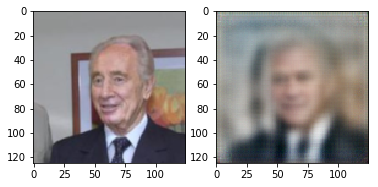

In [50]:
# from train set
for img in dataloader:
  img = Variable(img).cuda()
  reconstructed, latent_code = model(img)
  break

_, axarr = plt.subplots(1,2)
axarr[0].imshow((img.cpu()[0]).view(3, img_height, img_length).permute(1, 2, 0))
axarr[1].imshow(to_img(reconstructed[0].cpu().data).permute(1, 2, 0))

1324
1284
torch.Size([1, 3, 125, 125])


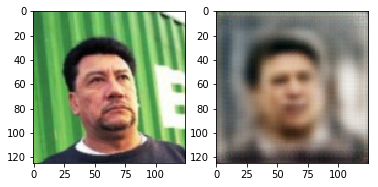

In [51]:
# from test set
print(len(face_dataset.X_test))
rand_idx = randint(0, len(face_dataset.X_test) - 1)
print(rand_idx)

img = face_dataset.X_test[rand_idx].view(1,3,125,125)
img = Variable(img).cuda()
print(img.shape)
reconstructed, latent_code = model(img)

_, axarr = plt.subplots(1,2)
axarr[0].imshow((img.cpu()[0]).view(3, img_height, img_length).permute(1, 2, 0))
axarr[1].imshow(to_img(reconstructed[0].cpu().data).permute(1, 2, 0))

torch.Size([1, 3, 125, 125])


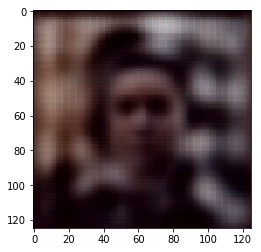

In [56]:
# generate a random face
generated = model.generate_random_face()
#generated *= 10 # increase brightness
print(generated.shape)
plt.imshow(to_img(generated.cpu().data).permute(1, 2, 0))

Лепим улыбку

In [0]:
transform = transforms.Compose([
              transforms.Resize((125, 125)),
              transforms.ToTensor(), ])

In [0]:
happy_dataset = [] 

for image in os.listdir(data_path  + 'happy'):
  img = Image.open(data_path + 'happy' + '/' + image)
  img = transform(img)
  happy_dataset.append(img)

In [0]:
unhappy_dataset = [] 

for image in os.listdir(data_path  + 'unhappy'):
  img = Image.open(data_path + 'unhappy' + '/' + image)
  img = transform(img)
  unhappy_dataset.append(img)

16 16


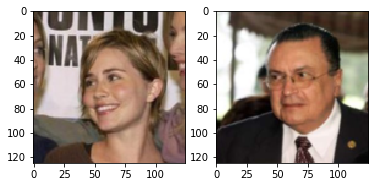

In [60]:
random_index = random.randint(0, len(happy_dataset)-1)

print(len(happy_dataset), len(unhappy_dataset))
_, axarr = plt.subplots(1,2)
axarr[0].imshow(happy_dataset[random_index].permute(1, 2, 0))
axarr[1].imshow(unhappy_dataset[random_index].permute(1, 2, 0))

In [0]:
mean_latent_code_happy = 0
mean_latent_code_unhappy = 0

for img_happy, img_unhappy in zip(happy_dataset,unhappy_dataset):
  img_happy = img_happy.view(1, 3, 125, 125)
  img_unhappy = img_unhappy.view(1, 3, 125, 125)
  
  img_happy = Variable(img_happy).cuda()
  img_unhappy = Variable(img_unhappy).cuda()
  
  reconstruction_happy, latent_code_happy = model(img_happy)
  mean_latent_code_happy += latent_code_happy/16
#  latent_codes_happy.append(latent_code_happy)
  
  reconstruction_unhappy, latent_code_unhappy = model(img_unhappy)
  mean_latent_code_unhappy += latent_code_unhappy/16
#  latent_codes_unhappy.append(latent_code_unhappy)
  
#print(mean_latent_code_happy, mean_latent_code_unhappy)

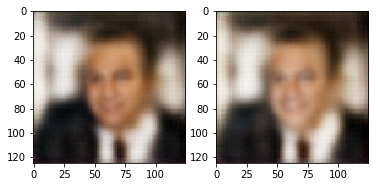

In [62]:
diff_vector = mean_latent_code_happy - mean_latent_code_unhappy

img_unhappy = unhappy_dataset[random_index]
img_unhappy = img_unhappy.view(1, 3, 125, 125)
img_unhappy = Variable(img_unhappy).cuda()

reconstruction_unhappy, latent_code_unhappy = model(img_unhappy)

add_smile = latent_code_unhappy + diff_vector
simely = model.decoder(add_smile)

_, axarr = plt.subplots(1,2)
axarr[0].imshow(to_img(reconstruction_unhappy.cpu().data).permute(1, 2, 0))
axarr[1].imshow(to_img(simely.cpu().data).permute(1, 2, 0))

## Шаг 3

Если вы смогли подобрать параметры сети и обучить ее, то пора начать играться =)

Играться можно так:

а) сгенерировать рандомные латентные векторы (без энкодера, например, с помощью np.random.randn), скормить их decoder'у и посмотреть, что получится. То есть, вы сможете создавать новые лица людей из векторов

б) Второе, что предлагается сделать -- научить лепить улыбки на лица грустных людей.

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии)

# BONUS 1. 
### Variational Autoencoder

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

В этом бонусе предлагается научиться реализовывать Variational autoencoders. После этого с ним можно точно так же играться -- генерить новых людей (кстати, сравните с тем, как генерит обычный автоэнкодер -- кто круче и почему?) пририсовывать улыбки тем же самым способом, что и для обычного autoencoder. Вперед!